In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [4]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [6]:
discipline = "Surgery"

In [7]:
foo = data_grouped_by_year_label[["Label"]].groupby(data_grouped_by_year_label.Label).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
foo.head(30)


,Label,counts
248,Zoology,117
87,Evolutionary Biology,117
33,"Chemistry, Inorganic & Nuclear",117
85,Ethics,117
35,"Chemistry, Multidisciplinary",117
139,"Materials Science, Multidisciplinary",117
201,Psychology,117
39,Clinical Neurology,117
200,Psychiatry,117
197,Political Science,117


In [8]:
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [9]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words
18889,18889,Surgery,1900,[complete series clinical charts keeping recor...,"[conical stump amputation childhood, report ca...",conical stump amputation childhood report case...,conical stump amputation childhood report case...
18890,18890,Surgery,1901,"[report three cases properitoneal hernia, repo...",[value rontgen method diagnosis detecting excl...,value rontgen method diagnosis detecting exclu...,value rontgen method diagnosis detecting exclu...
18891,18891,Surgery,1902,"[intussusception meckel s diverticulum , intus...",[ligation lingual artery mouth excising half t...,ligation lingual artery mouth excising half to...,ligation lingual artery mouth excising half to...
18892,18892,Surgery,1903,"[aspirating trocar, aspirating trocar, treatme...",[test whether cathelin urine divisor forms per...,test whether cathelin urine divisor forms perf...,test whether cathelin urine divisor forms perf...
18893,18893,Surgery,1904,[skin grafting treatment complete stenosis lar...,"[transverse ectopy testis, segmented ring gast...",transverse ectopy testis segmented ring gastri...,transverse ectopy testis segmented ring gastri...


In [10]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

In [11]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

In [12]:
vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [13]:
vectorized_wordarray.shape

(117, 101240)

In [14]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:00<00:00, 134.68it/s]


In [15]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

__Frequency Variations:__ Words which have a frequency of 20 in year Y<sub>t</sub>. How much do they normally vary in years Y<sub>t+1</sub>, t<sub>t+2</sub> etc. 

In [16]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
#         if index == 49 and uniq == 12:
#             import ipdb
#             ipdb.set_trace()
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:01<00:00, 68.66it/s]


In [17]:
len(yearly_word_frequency_variations)

116

__Word Frequency Variations Plot | Year__

__Year:__ 2011

In [18]:
input_.iloc[111:112]

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
19000,19000,Surgery,2011,[stereotactic 125 iodine brachytherapy treatm...,[laparoscopic common bile duct exploration eld...,laparoscopic common bile duct exploration elde...,laparoscopic common bile duct exploration elde...,68738,331619


Total count of papers: 42160
Total count of words: 400963

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1584 words with 3 counts
1721 words with 3 counts
1668 words with 3 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1712 words with 3 counts
1771 words with 3 counts
1701 words with 3 counts


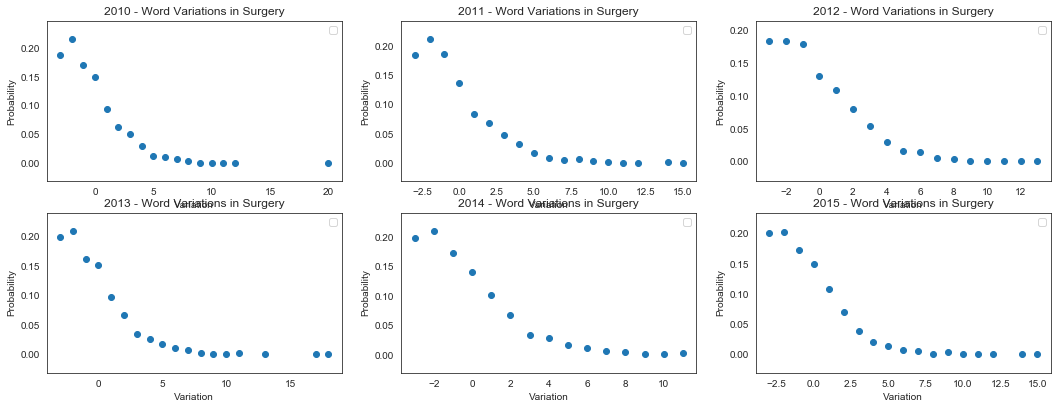

In [19]:
K = 3
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


738 words with 5 counts
736 words with 5 counts
785 words with 5 counts
791 words with 5 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


747 words with 5 counts
780 words with 5 counts


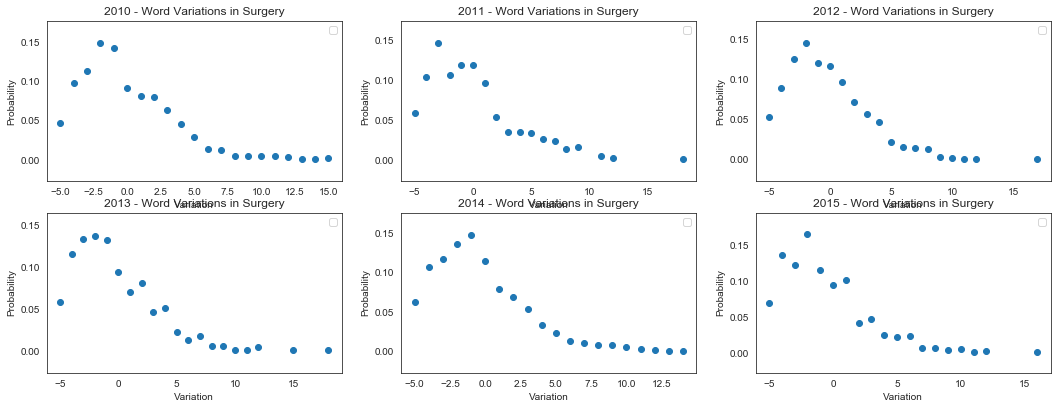

In [20]:
K = 5
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


440 words with 7 counts
467 words with 7 counts
475 words with 7 counts
454 words with 7 counts
459 words with 7 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


478 words with 7 counts


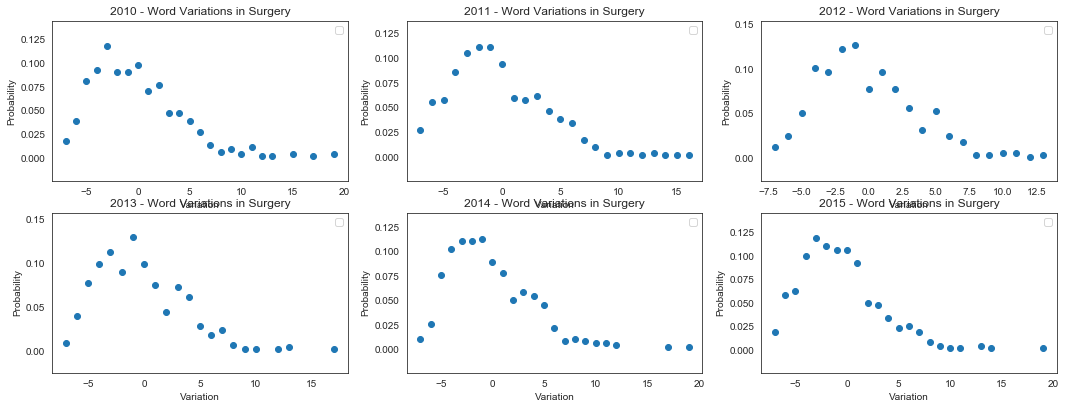

In [21]:
K = 7
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

252 words with 10 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


264 words with 10 counts
293 words with 10 counts
262 words with 10 counts
285 words with 10 counts
285 words with 10 counts


No handles with labels found to put in legend.


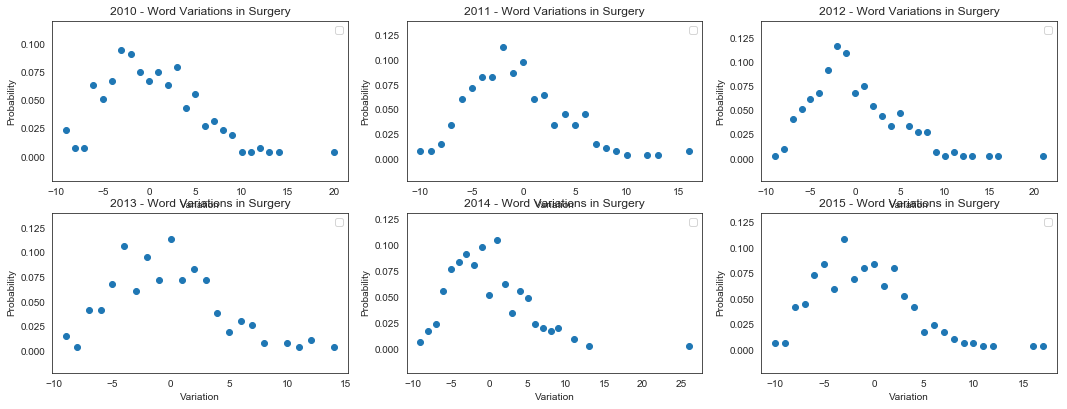

In [22]:
K = 10
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


142 words with 15 counts
157 words with 15 counts
136 words with 15 counts
159 words with 15 counts
150 words with 15 counts


No handles with labels found to put in legend.
No handles with labels found to put in legend.


146 words with 15 counts


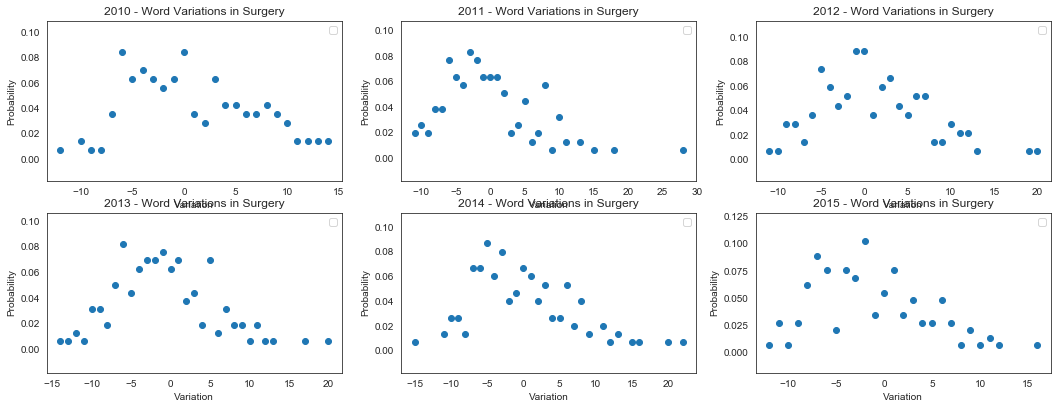

In [23]:
K = 15
f = plt.figure(figsize=(18,10))


year = 2010
N = 110
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(331)
ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()


year = 2011
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax2 = f.add_subplot(332)
ax2.scatter(X, Y)
ax2.set_xlabel("Variation")
ax2.set_ylabel("Probability")
ax2.set_title(str(year) + " - Word Variations in " + discipline)
ax2.legend()


year = 2012
N = 112
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax3 = f.add_subplot(333)
ax3.scatter(X, Y)
ax3.set_xlabel("Variation")
ax3.set_ylabel("Probability")
ax3.set_title(str(year) + " - Word Variations in " + discipline)
ax3.legend()


year = 2013
N = 113
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax4 = f.add_subplot(334)
ax4.scatter(X, Y)
ax4.set_xlabel("Variation")
ax4.set_ylabel("Probability")
ax4.set_title(str(year) + " - Word Variations in " + discipline)
ax4.legend()


year = 2014
N = 114
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax5 = f.add_subplot(335)
ax5.scatter(X, Y)
ax5.set_xlabel("Variation")
ax5.set_ylabel("Probability")
ax5.set_title(str(year) + " - Word Variations in " + discipline)
ax5.legend()



year = 2015
N = 115
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]
ax6 = f.add_subplot(336)
ax6.scatter(X, Y)
ax6.set_xlabel("Variation")
ax6.set_ylabel("Probability")
ax6.set_title(str(year) + " - Word Variations in " + discipline)
ax6.legend()

In [29]:
counts_ = dict(Counter(variations)).values()
counts_

dict_values([12, 15, 9, 1, 6, 10, 13, 3, 8, 9, 8, 2, 5, 2, 1, 11, 7, 3, 5, 2, 2, 1, 1, 1])

In [27]:
len(indices)

137

No handles with labels found to put in legend.


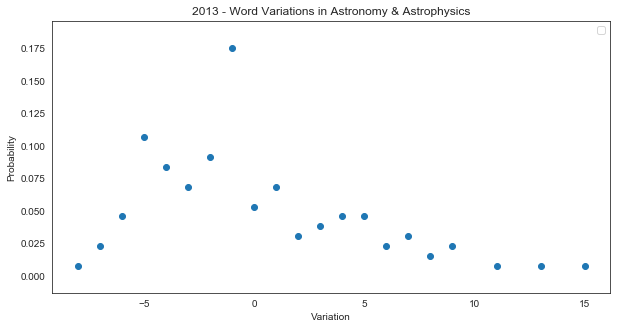

In [32]:
year = 2013

N = 112
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  


f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


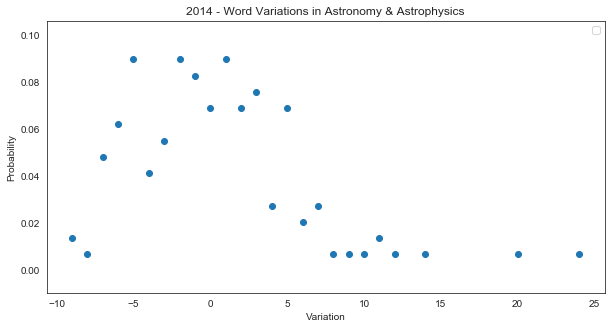

In [33]:
year = 2014

N = 113
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]


variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()

No handles with labels found to put in legend.


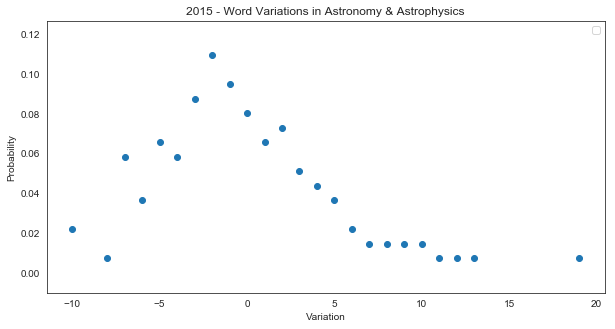

In [34]:
year = 2015

N = 114
K = 10

freq50 = list(vectorized_wordarray[N:N+1,:][0])
freq51 = list(vectorized_wordarray[N+1:N+2,:][0])

indices = [i for i, x in enumerate(freq50) if x == K]
change_in_values = [freq51[i] for i in indices]

variations = [j - K for j in change_in_values]

sum_ = sum(dict(Counter(variations)).values())

from collections import Counter

X = [x for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  



f = plt.figure(figsize=(10,5))

ax = f.add_subplot(111)

ax.scatter(X, Y)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)
ax.legend()